# QOSF mentorship program screening task 2

### Author
Mengdi Zhao

### Tools
Jupyter notebook and Qiskit

### Task 2
The bit-flip code and the sign-flip code are two very simple circuits able to detect and fix the bit-flip and the sign-flip errors, respectively.
1.	Build the circuit to prepare the Bell state. 
2.	Now add, right before the CNOT gate and for each of the two qubits, an arbitrary “error gate”. By error gate we mean that with a certain probability (that you can decide but must be non-zero for all the choices) you have a 1 qubit unitary which can be either the identity, or the X gate (bit-flip error) or the Z gate (sign-flip error).
3.	Encode each of the two qubits with a sign-flip or a bit-flip code, in such a way that all the possible choices for the error gates described in 2), occurring on the logical qubits, can be detected and fixed. Motivate your choice. This is the most non-trivial part of the problem, so do it with a lot of care!
4.	Test your solution by making many measurements over the final state and testing that the results are in line with the expectations.


## Content:
***
1. **Basic tasks:**
 * Build the circuit to prepare Bell state
 * Add the error gate
 * Design the error correction circuit
 * Simulate mutiple times and visulize the results
 
2. **A more general case**
3. **Conclusion**
***

## Basic tasks

#### Let's first define all the fuctions needed.

In [810]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.quantum_info import Statevector, state_fidelity
from qiskit.visualization import plot_state_qsphere, plot_histogram
from qiskit import Aer, execute

import collections
from collections import Counter
import random
import matplotlib.pyplot as plt

In [811]:
# This is the function that will add an error gate of ...
# ... X (with probability p=p_error_X/100), or Z (p=p_error_Z/100) or I (p=(100-p_error_X-p_error_Z)/100)...
# ... to the qubit named qubit_applied in a circuit named given_circuit.

def error_gate(given_circuit, qubit_applied,p_error_X,p_error_Z):  
    p_I=100-p_error_X-p_error_Z      
    for i in qubit_applied:
        n=random.choice([1]*p_error_X + [2]*p_error_Z + [3]*p_I)
        if (n==1):    
            given_circuit.x(i)
        elif (n==2):
            given_circuit.z(i)
        else:
            given_circuit.i(i)

    return given_circuit


# This is the function that will generate the error-correction circuit for a single logical qubit.
# The error gate is already included in this circuit and is applied only on the logical qubit.
# qubits_repeat are the ancillary qubits needed for the logical qubit called qubit_error_applied

def error_correction_simple(given_circuit, qubit_error_applied,qubits_repeat,p_error_x,p_error_z):  
    given_circuit.cx(qubit_error_applied,qubits_repeat[1])
    given_circuit.h(qubit_error_applied)    
    given_circuit.h(qubits_repeat[1])
    given_circuit.barrier(qubit_error_applied,qubits_repeat)
    given_circuit.cx(qubit_error_applied,qubits_repeat[0])

    # call the function to generate the error gate
    error_gate(given_circuit, qubit_error_applied,p_error_x,p_error_z)

    given_circuit.cx(qubit_error_applied,qubits_repeat[0])
    given_circuit.cx(qubits_repeat[0],qubit_error_applied)
    given_circuit.barrier(qubit_error_applied,qubits_repeat)
    given_circuit.h(qubit_error_applied)    
    given_circuit.h(qubits_repeat[1])
    given_circuit.cx(qubit_error_applied,qubits_repeat[1])
    given_circuit.cx(qubits_repeat[1],qubit_error_applied)

    return given_circuit


# This is the function that will generate the error-correction circuit for a single logical qubit.
# The error gate is included in this circuit already and is applied on the logical qubit as well as the ancillary qubits.

def error_correction_shor(given_circuit, qubit_error_applied,qubits_repeat,p_error_x,p_error_z):  
    given_circuit.cx(qubit_error_applied,qubits_repeat[2])
    given_circuit.cx(qubit_error_applied,qubits_repeat[5])
    given_circuit.h(qubit_error_applied)    
    given_circuit.h(qubits_repeat[2])
    given_circuit.h(qubits_repeat[5])
    given_circuit.cx(qubit_error_applied,qubits_repeat[0])
    given_circuit.cx(qubit_error_applied,qubits_repeat[1])
    given_circuit.cx(qubits_repeat[2],qubits_repeat[3])
    given_circuit.cx(qubits_repeat[2],qubits_repeat[4])
    given_circuit.cx(qubits_repeat[5],qubits_repeat[6])
    given_circuit.cx(qubits_repeat[5],qubits_repeat[7])

    # call the function to generate the error gate
    error_gate(given_circuit, qubit_error_applied,p_error_x,p_error_z)
    error_gate(given_circuit, qubits_repeat,p_error_x,p_error_z)

    given_circuit.cx(qubit_error_applied,qubits_repeat[0])
    given_circuit.cx(qubit_error_applied,qubits_repeat[1])
    given_circuit.cx(qubits_repeat[2],qubits_repeat[3])
    given_circuit.cx(qubits_repeat[2],qubits_repeat[4])
    given_circuit.cx(qubits_repeat[5],qubits_repeat[6])
    given_circuit.cx(qubits_repeat[5],qubits_repeat[7])
    
    given_circuit.ccx(qubits_repeat[1],qubits_repeat[0],qubit_error_applied)
    given_circuit.ccx(qubits_repeat[4],qubits_repeat[3],qubits_repeat[2])
    given_circuit.ccx(qubits_repeat[7],qubits_repeat[6],qubits_repeat[5])
    given_circuit.h(qubit_error_applied)    
    given_circuit.h(qubits_repeat[2])
    given_circuit.h(qubits_repeat[5])
    given_circuit.cx(qubit_error_applied,qubits_repeat[2])
    given_circuit.cx(qubit_error_applied,qubits_repeat[5])
    given_circuit.ccx(qubits_repeat[5],qubits_repeat[2],qubit_error_applied)

    return given_circuit


# This function is for data visualization

def plot_data(data):
    p = collections.Counter(data)
    probability=[]
    # convert counts to probabilities
    for value in p.values():
        probability.extend([value/sum(p.values())])   
    xlocs, xlabs = plt.xticks()
    xlocs=[i+1 for i in range(0,len(p.keys()))]
    xlabs=[i/2 for i in range(0,len(p.keys()))]  
    plt.bar(p.keys(), probability)
    for i, v in enumerate(probability):
        plt.text(xlocs[i] - 1.15, v+0.01 , str(v))
    plt.title('Distribution of  Measurement Results')
    plt.xlabel('Measurement results')
    plt.ylabel('Probabilities')
    plt.ylim((0,0.6))

### 1. Buld the circuit to prepare Bell state

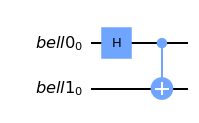

In [812]:
bell_qubit0 = QuantumRegister(1,'bell0')
bell_qubit1 = QuantumRegister(1,'bell1')
BellCircuit = QuantumCircuit(bell_qubit0,bell_qubit1)
BellCircuit.h(0)
BellCircuit.cx(0,1)
BellCircuit.draw('mpl')

### 2. Add the error gates

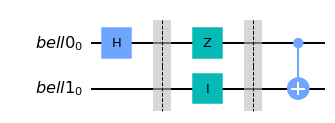

In [843]:
bell_qubit0 = QuantumRegister(1,'bell0')
bell_qubit1 = QuantumRegister(1,'bell1')
BellCircuit_error = QuantumCircuit(bell_qubit0,bell_qubit1)

# Set the probability in percentage 
[p_error_x,p_error_z]=[30,30]  # only integer is allowed. 30 means 30% error probability

BellCircuit_error.h(0)
BellCircuit_error.barrier()
# Randomly (follow the preset probability) add an error gate to each logical qubits
error_gate(BellCircuit_error,[bell_qubit0,bell_qubit1],p_error_x,p_error_z)
BellCircuit_error.barrier()
BellCircuit_error.cx(0,1)

BellCircuit_error.draw('mpl')


### 3. Design the error correction circuit
For now, let's assume the error occurs only on the logical qubit (bell0 and bell1), not on the ancillary qubits that will be used to detect and correct errors. For each logical qubit, I encode it with an error-correction code, which is a combination of the bit-flip code and sign-flip code. Since we assume the error occurs only on the logical qubits, this code is a simplified version of Shor code. Now let's build the error-correction circuit for a logical qubit (in an arbitrary initial state) first and I will explain why it works. 

As is shown in the circuit below, logical0 is the qubit that matters and that errors will act on. The ancilla0 and 1 are two ancilary qubits that will help detect and correct error.

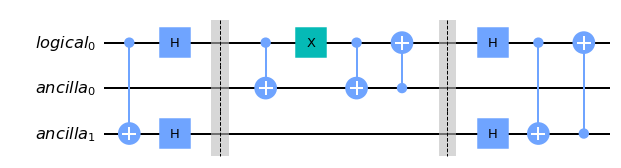

In [850]:
# set the error probability
[p_error_x,p_error_z]=[30,30] 

logical_qubit = QuantumRegister(1,'logical')
qubits_repeat = QuantumRegister(2,'ancilla') 

Circuit_ErrorCorrection = QuantumCircuit(logical_qubit,qubits_repeat)
# apply the error correction code together with the error gate
error_correction_simple(Circuit_ErrorCorrection, logical_qubit,qubits_repeat,p_error_x,p_error_z)

Circuit_ErrorCorrection.draw('mpl')

This circuit is a combination of bit-flip code and sign-flip code. Now let's discuss why it works. Assume we have an arbitrary single logical qubit $\big|\psi\rangle=\alpha \big|0\rangle+\beta \big|1\rangle$ and two ancillary qubits both in state $\big|0\rangle$.
The initial state of the whole system is therefore $\big|\phi_0\rangle=\big|\psi\rangle\big|00\rangle$. Right before the error occurs, the systems state has evolved into: 
$$\big|\phi_1\rangle=1/\sqrt2 \big(\alpha\big|00+\rangle+\alpha\big|11+\rangle+\beta\big|00-\rangle-\beta\big|11-\rangle\big)$$

Let's consider three senarios: 
* A bit-flip error occurs on the logical qubit:
    
    This means right after the error gate, the state becomes $\big|\phi_2\rangle=1/\sqrt2 \big(\alpha\big|10+\rangle+\alpha\big|01+\rangle+\beta\big|10-\rangle-\beta\big|01-\rangle\big)$. Then at the end of the circuit, we can get the final state: $\big|\phi_3\rangle=\big|\psi\rangle\big|10\rangle$, which means we have corrected the error that occurs on $\big|\psi\rangle$. And the ancilla0 qubit being 1 is an indication of a bit-flip error occurred.


* A sign-flip error occurs on the logical qubit:
    
    This means right after the error gate, the state becomes $\big|\phi_2^{\prime}\rangle=1/\sqrt2 \big(\alpha\big|00+\rangle-\alpha\big|11+\rangle+\beta\big|00-\rangle+\beta\big|11-\rangle\big)$. Then at the end of the circuit, we can get the final state: $\big|\phi_3^{\prime}\rangle=\big|\psi\rangle\big|01\rangle$, which means we have corrected the error that occurs on $\big|\psi\rangle$. And the ancilla1 qubit being 1 will indicate a sign-flip error occurred.


* No error occurs:
    
    It's easy to tell that the final state $\big|\phi_3^{\prime\prime}\rangle=\big|\phi_0\rangle=\big|\psi\rangle\big|00\rangle$.


**Next step is to integrate the error-correction circuit with the circuit that generates the Bell state and run the simulations.**

### 4. Simulate mutiple times and visulize the results

In [851]:
# set the error probability
[p_error_x,p_error_z]=[30,30]  

# Set the simulator and number of simulations
simulator = Aer.get_backend('qasm_simulator')
# number of simulations
N=1000
# to store the results
data = []

bell_qubit0 = QuantumRegister(1,'bell0')
bell_qubit0_repeat = QuantumRegister(2,'ancilla0')
bell_qubit1 = QuantumRegister(1,'bell1')
bell_qubit1_repeat = QuantumRegister(2,'ancilla1')
cl = ClassicalRegister(2,'c')

for x in range(N):    
    BellCircuit_ErrorCorrection = QuantumCircuit(bell_qubit0,bell_qubit0_repeat,bell_qubit1,bell_qubit1_repeat,cl)
    BellCircuit_ErrorCorrection.h(0)
    BellCircuit_ErrorCorrection.barrier()
    error_correction_simple(BellCircuit_ErrorCorrection, bell_qubit0,bell_qubit0_repeat,p_error_x,p_error_z)
    error_correction_simple(BellCircuit_ErrorCorrection, bell_qubit1,bell_qubit1_repeat,p_error_x,p_error_z)
    BellCircuit_ErrorCorrection.barrier()
    BellCircuit_ErrorCorrection.cx(0,3)
    BellCircuit_ErrorCorrection.measure([0,3], [0,1])
    result = execute(BellCircuit_ErrorCorrection, simulator, shots=1, memory=True).result()   
    data.extend(result.get_memory(BellCircuit_ErrorCorrection))


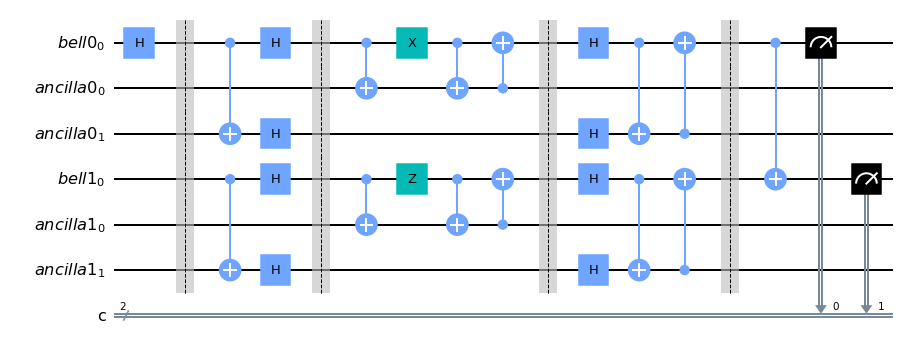

In [854]:
# Show the circuit of the last run
BellCircuit_ErrorCorrection.draw('mpl')

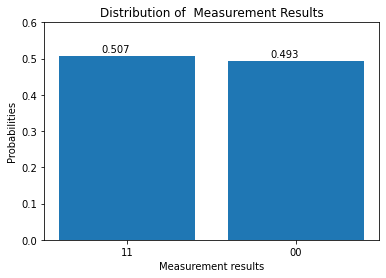

In [855]:
# Visualize the results   
plot_data(data)

As we can see, the results ($00$ and $11$) and their distribution (close to 50%, respectibvely) are in line with the expectations of measuring a Bell state, even when the probabilities of error X and Z are as high as 30%, respectively. Actually, no matter what the error probability is, the circuit defined in function error_correction_simple can always successfully correct the error. This is becasue the error only occurs on logical qubits.

A more general and realistic case is that both the logical qubit and the ancillary qubits will experience error, becasue usually they pass through some noisy channels together. This brings us to the next section.

## A more general case

Let's make some assumptions first:
1. All qubits, including logical and ancillary qubits, will experience error (For simplicity, they have the same probability distribution in the types of errors.)
2. For simplicity, the error probability $p$=p_error_z+p_error_z is small enough so that the probability of more than one qubit having error is negligible. 

This is what Shor code is about and we are going to implement Shor code with circuit. 

There are 8 ancillary qubits for each logical qubit (9 qubits in total), so the probability of one qubit having error is $C^1_9p(1-p)^8$, and two qubits having error is $C^2_9p^2(1-p)^7$. In order for assumption 2 to be valid, we need to make sure $C^2_9p^2(1-p)^7<<C^1_9p(1-p)^8$, which is $p<<0.25$, so $p$ should roughly statisfy $p<=2.5\%$. Therefore, I will choose to use p_error_x=p_error_z=1%.

In [835]:
# set the error probability
[p_error_x,p_error_z]=[1,1]

simulator = Aer.get_backend('qasm_simulator')
# number of simulations
N=1000
data = []

bell_qubit0 = QuantumRegister(1,'bell0')
bell_qubit0_repeat = QuantumRegister(8,'ancilla0')
bell_qubit1 = QuantumRegister(1,'bell1')
bell_qubit1_repeat = QuantumRegister(8,'ancilla1')
cl = ClassicalRegister(2,'c')


for x in range(N):

    BellCircuit_ShorErrorCorrection = QuantumCircuit(bell_qubit0,bell_qubit0_repeat,bell_qubit1,bell_qubit1_repeat,cl)
    BellCircuit_ShorErrorCorrection.h(0)
    BellCircuit_ShorErrorCorrection.barrier()
    error_correction_shor(BellCircuit_ShorErrorCorrection, bell_qubit0,bell_qubit0_repeat,p_error_x,p_error_z)
    error_correction_shor(BellCircuit_ShorErrorCorrection, bell_qubit1,bell_qubit1_repeat,p_error_x,p_error_z)
    BellCircuit_ShorErrorCorrection.barrier()
    BellCircuit_ShorErrorCorrection.cx(0,9)
    BellCircuit_ShorErrorCorrection.measure([0,9], [0,1])
    result = execute(BellCircuit_ShorErrorCorrection, simulator, shots=1, memory=True).result()   
    data.extend(result.get_memory(BellCircuit_ShorErrorCorrection))


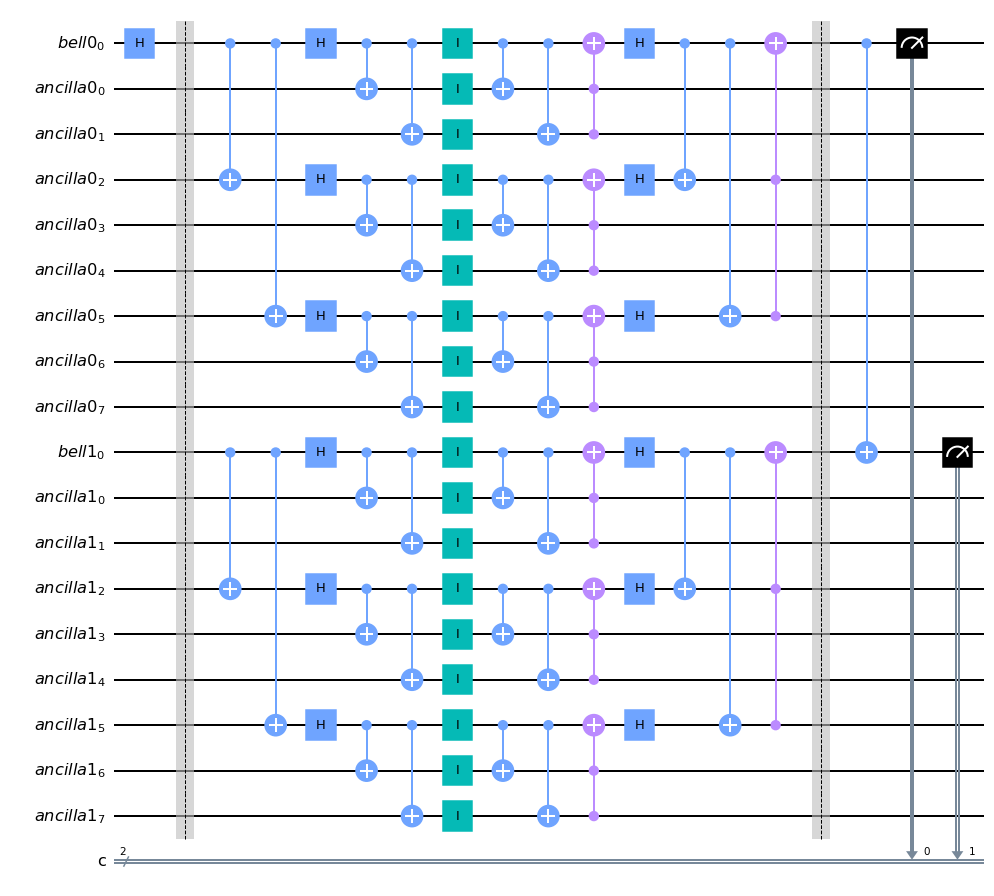

In [836]:
# Show the circuit of the last run 
BellCircuit_ShorErrorCorrection.draw('mpl')

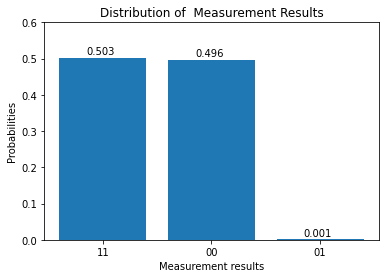

In [837]:
# Visualize the results   
plot_data(data)

As we can see, we measured $00$ and $11$ with close to 50% probability respectively, which is in line with our expectations. There is very little chance (0.1% in the above figure) that we will get $01$ and $10$ at the output.

Let's compare the results with the case that has the same error probability but without the error-correction code to confirm the effect of the error correction code. 

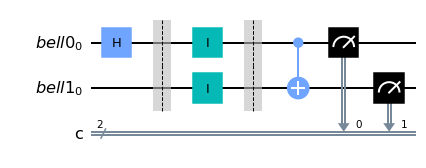

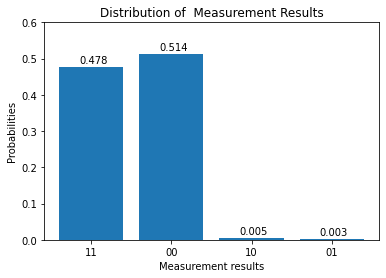

In [839]:
# without error correction 
[p_error_x,p_error_z]=[1,1] 
N=1000
data=[] 

bell_qubit0 = QuantumRegister(1,'bell0')
bell_qubit1 = QuantumRegister(1,'bell1')
cl = ClassicalRegister(2,'c')

for x in range(N):
    BellCircuit_error = QuantumCircuit(bell_qubit0,bell_qubit1,cl)

    BellCircuit_error.h(0)
    BellCircuit_error.barrier()
    # Randomly (follow the preset probability) add an error gate to each logical qubits
    error_gate(BellCircuit_error,[bell_qubit0,bell_qubit1],p_error_x,p_error_z)
    BellCircuit_error.barrier()
    BellCircuit_error.cx(0,1)
    BellCircuit_error.measure([0,1], [0,1])
    result = execute(BellCircuit_error, simulator, shots=1, memory=True).result()   
    data.extend(result.get_memory(BellCircuit_error))
    
plot_data(data)   

# Show the circuit of the last run
BellCircuit_error.draw('mpl')


We can see the probabilities of $10$ and $01$ outputs are several times larger than the case with error correction, which means the error-correction circuit indeed works.

If we compare the results of those two cases (with and without error-correction code) again at a higher error probability $p=10\%$, what will happen?

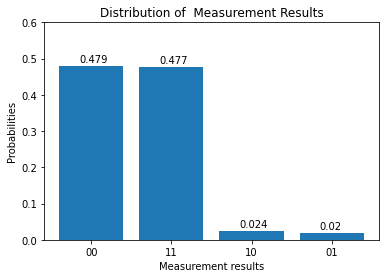

In [840]:
# with error correction 
[p_error_x,p_error_z]=[5,5]

simulator = Aer.get_backend('qasm_simulator')
# number of simulations
N=1000
data = []

bell_qubit0 = QuantumRegister(1,'bell0')
bell_qubit0_repeat = QuantumRegister(8,'ancilla0')
bell_qubit1 = QuantumRegister(1,'bell1')
bell_qubit1_repeat = QuantumRegister(8,'ancilla1')
cl = ClassicalRegister(2,'c')

for x in range(N):

    BellCircuit_ShorErrorCorrection = QuantumCircuit(bell_qubit0,bell_qubit0_repeat,bell_qubit1,bell_qubit1_repeat,cl)
    BellCircuit_ShorErrorCorrection.h(0)
    BellCircuit_ShorErrorCorrection.barrier()
    error_correction_shor(BellCircuit_ShorErrorCorrection, bell_qubit0,bell_qubit0_repeat,p_error_x,p_error_z)
    error_correction_shor(BellCircuit_ShorErrorCorrection, bell_qubit1,bell_qubit1_repeat,p_error_x,p_error_z)
    BellCircuit_ShorErrorCorrection.barrier()
    BellCircuit_ShorErrorCorrection.cx(0,9)
    BellCircuit_ShorErrorCorrection.measure([0,9], [0,1])
    result = execute(BellCircuit_ShorErrorCorrection, simulator, shots=1, memory=True).result()   
    data.extend(result.get_memory(BellCircuit_ShorErrorCorrection))

plot_data(data)

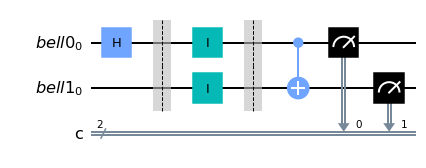

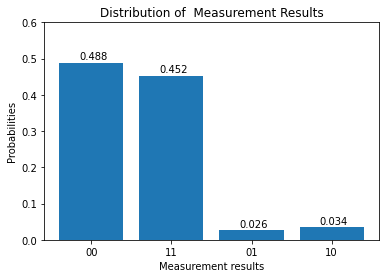

In [834]:
# without error correction 
[p_error_x,p_error_z]=[5,5] 
N=1000
data=[]

bell_qubit0 = QuantumRegister(1,'bell0')
bell_qubit1 = QuantumRegister(1,'bell1')
cl = ClassicalRegister(2,'c')
 
for x in range(N):
    BellCircuit_error = QuantumCircuit(bell_qubit0,bell_qubit1,cl)

    BellCircuit_error.h(0)
    BellCircuit_error.barrier()
    # Randomly (follow the preset probability) add an error gate to each logical qubits
    error_gate(BellCircuit_error,[bell_qubit0,bell_qubit1],p_error_x,p_error_z)
    BellCircuit_error.barrier()
    BellCircuit_error.cx(0,1)
    BellCircuit_error.measure([0,1], [0,1])
    result = execute(BellCircuit_error, simulator, shots=1, memory=True).result()   
    data.extend(result.get_memory(BellCircuit_error))
    
plot_data(data)   

# Show the circuit of the last run
BellCircuit_error.draw('mpl')


Compare the two results, we can find that they show similar probabilities of getting $01$ and $10$, which means the error-correction code in function error_correction_shor is not helping. This is because $p$ is too high and the case that more than 1 qubit have error is not negligible.

## Conclusion 

1. If the error gate only acts on the logical qubit, then only two ancillary qubits are needed to detect and correct the error of each logical qubit. Also, the error correction circuit will 100% work, no matter how high the error probability is.
2. If the error gates apply on all the qubits involved (logical and ancillary qubits), then at least 8 ancillary qubits for each logical qubit are needed. I have studied the case with the assumption that the chance of more than one qubits having errors is negligible. 